In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense      # create layers

train = pd.read_csv('../input/train.csv')
test  = pd.read_csv('../input/test.csv')

train['IsTrain'] = True
test['IsTrain'] = False
df = train.append(test, ignore_index = True)

print(df.info())

Using TensorFlow backend.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
IsTrain        1309 non-null bool
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 124.1+ KB
None


## Completing.. ##

In [2]:
#Complete the missing ages with the median.
df['Age'].fillna(df['Age'].median(), inplace = True)
#Complete the missing embarks with the most embarkeds. 
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)
print(df.isnull().sum())

Age               0
Cabin          1014
Embarked          0
Fare              1
IsTrain           0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64


## Feature Engineering.. ##

In [3]:
df['fe_Title'] = df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip()) 
df['fe_SimpleTitle'] = df['fe_Title']
df['fe_SimpleTitle'] = df['fe_SimpleTitle'].replace('Mlle', 'Miss')
df['fe_SimpleTitle'] = df['fe_SimpleTitle'].replace(['Mme','Lady','Ms'], 'Mrs')
df['fe_SimpleTitle'] = df['fe_SimpleTitle'].replace(['Rev','Dr', 
                                                           'Col', 'Major', 'Don', 
                                                           'Jonkheer', 'the Countess', 'Sir', 
                                                           'Dona', 'Capt'], 'Other')

#train['fe_SimpleTitle'].value_counts()
df['fe_FamilySize'] = df.SibSp + df.Parch + 1

#Take the first character of the ticket
df.Ticket = df.Ticket.map(lambda x: x[0])

df['Ticket'] = df['Ticket'].astype('str') 
df['Embarked'] = df['Embarked'].astype('str') 
estimated_Fare = df.Fare.loc[ (df.Ticket == '3') & 
                             (df.Pclass == 3) & 
                             (df.Embarked == 'S')].median()
                             
df.Fare.fillna(estimated_Fare , inplace=True)

df['fe_FareGroup'] = pd.qcut(df.Fare,5,labels=[1,2,3,4,5]).astype(int)

ageGroups = [ 0, 4, 12, 18, 30, 50, 65, 100]
age_index = (1,2,3,4,5,6,7)
#('baby','child','teenager','young','mid-age','over-50','old')
df['fe_AgeGroup'] = pd.cut(df.Age, ageGroups, labels=age_index).astype(int)


## Correcting.. ##

In [4]:
df.Sex = df.Sex.map({'male':0, 'female':1, 0:0, 1:1})
df.fe_FamilySize = df.fe_FamilySize.map(lambda x: 0 if x > 4 else x)
df.Embarked = df.Embarked.map({'C':0, 'Q':1, 'S':2, 0:0, 1:1, 2:2})

#Assumption: if family size > 4 then it is classified as "zero". 
#as the family size increases survival rate increases also
df[['fe_FamilySize', 'Survived']].groupby(['fe_FamilySize'], as_index=False).mean()



#We know there are two missing values for the Embarked, we fill it with the most common
df.Embarked.fillna('S' , inplace=True )

## Visualization.. ##

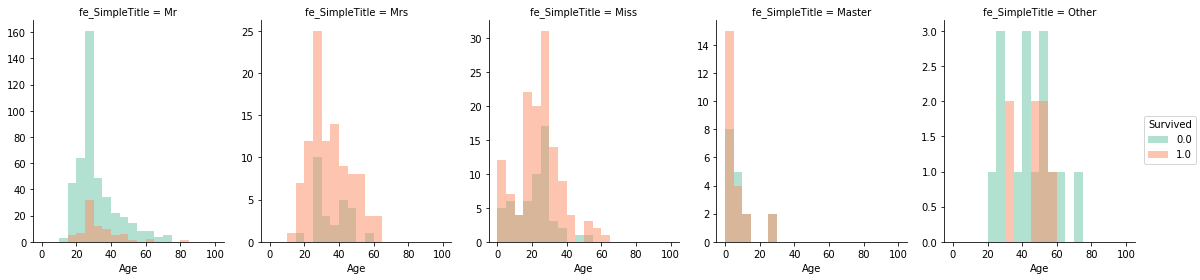

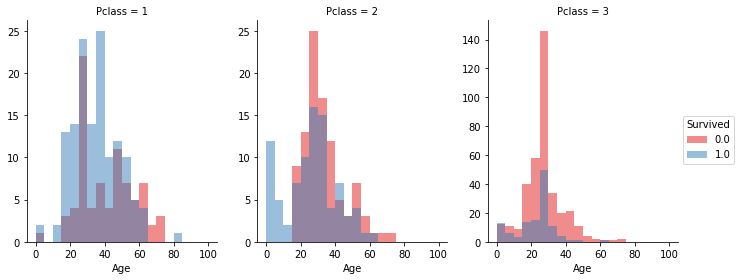

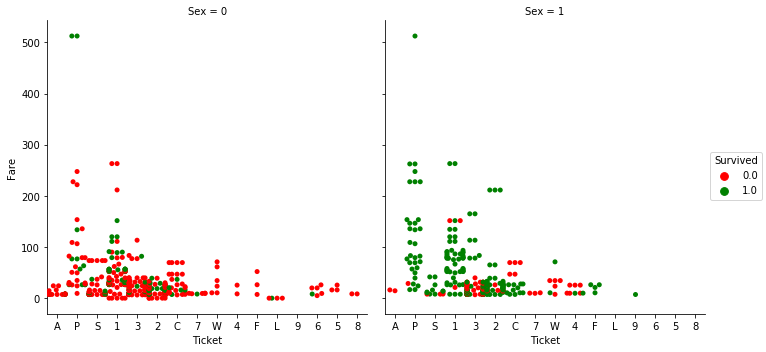

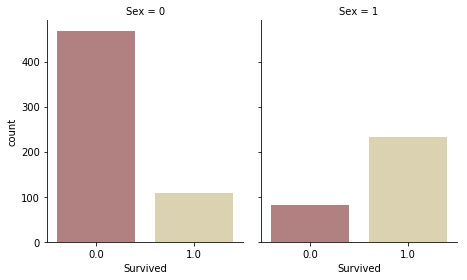

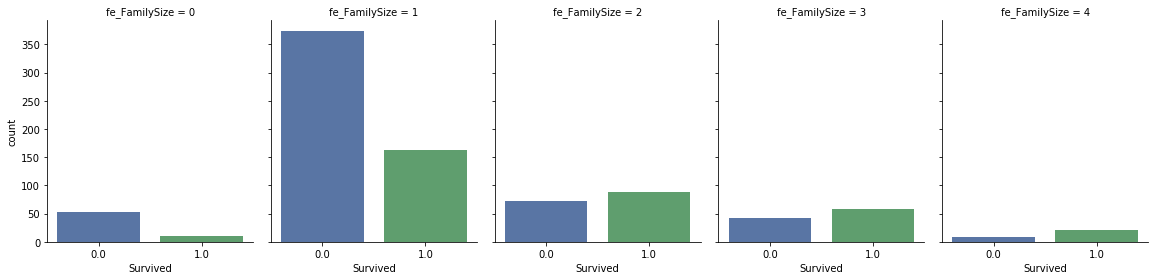

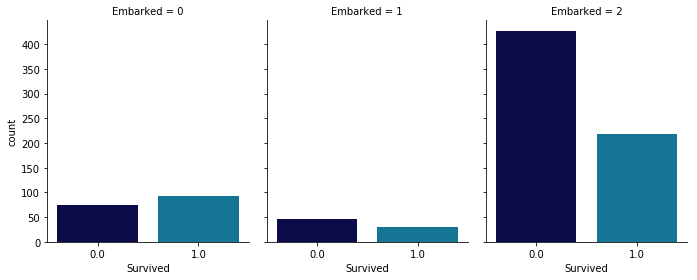

In [5]:
grid = sns.FacetGrid(df, col='fe_SimpleTitle', size=4, aspect=0.8, sharey=False, 
                     hue='Survived', palette='Set2')
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
grid.add_legend()
plt.show()

grid = sns.FacetGrid(df, col='Pclass', size=4, aspect=0.8, sharey=False, 
                     hue='Survived', palette='Set1')
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
grid.add_legend()
plt.show()

sns.factorplot(x="Ticket", y="Fare", hue="Survived", col="Sex", 
               kind="swarm",data=df, size = 5, palette={0.0:"r", 1.0:"g"})

pals = ['pink', 'deep', 'ocean', 'magma', 'Blues']

features = ['Sex', 'fe_FamilySize', 'Embarked']
i = 0
for f in features:
    sns.factorplot("Survived", col=f, data=df, size=4, kind="count", aspect=.8, palette= pals[i])
    i = i + 1

In [6]:
#Pivotting
if 'Piv_Title_Master' in df.columns:
    print("You have run this already. Do you want to duplicate your columns?")
else:
    df = pd.concat([df, pd.get_dummies(prefix='Piv_Title',data=df['fe_SimpleTitle'])], axis=1)
    df = pd.concat([df, pd.get_dummies(prefix='Piv_Ticket',data=df['Ticket'])], axis=1)

In [7]:
#Last Check, no null values. Good to go!
print(df.isnull().sum())

Age                    0
Cabin               1014
Embarked               0
Fare                   0
IsTrain                0
Name                   0
Parch                  0
PassengerId            0
Pclass                 0
Sex                    0
SibSp                  0
Survived             418
Ticket                 0
fe_Title               0
fe_SimpleTitle         0
fe_FamilySize          0
fe_FareGroup           0
fe_AgeGroup            0
Piv_Title_Master       0
Piv_Title_Miss         0
Piv_Title_Mr           0
Piv_Title_Mrs          0
Piv_Title_Other        0
Piv_Ticket_1           0
Piv_Ticket_2           0
Piv_Ticket_3           0
Piv_Ticket_4           0
Piv_Ticket_5           0
Piv_Ticket_6           0
Piv_Ticket_7           0
Piv_Ticket_8           0
Piv_Ticket_9           0
Piv_Ticket_A           0
Piv_Ticket_C           0
Piv_Ticket_F           0
Piv_Ticket_L           0
Piv_Ticket_P           0
Piv_Ticket_S           0
Piv_Ticket_W           0
dtype: int64


We will drop cabin, so we do not care for it now.
And the null values from survived comes from the test data.

In [8]:
if 'SibSp' in df.columns:
    df = df.drop(labels=['SibSp','Parch','Age','Fare', 'fe_Title', 
                                   'fe_SimpleTitle', 'Name', 'Cabin', 'Ticket'], axis=1)
    
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 30 columns):
Embarked            1309 non-null int64
IsTrain             1309 non-null bool
PassengerId         1309 non-null int64
Pclass              1309 non-null int64
Sex                 1309 non-null int64
Survived            891 non-null float64
fe_FamilySize       1309 non-null int64
fe_FareGroup        1309 non-null int64
fe_AgeGroup         1309 non-null int64
Piv_Title_Master    1309 non-null uint8
Piv_Title_Miss      1309 non-null uint8
Piv_Title_Mr        1309 non-null uint8
Piv_Title_Mrs       1309 non-null uint8
Piv_Title_Other     1309 non-null uint8
Piv_Ticket_1        1309 non-null uint8
Piv_Ticket_2        1309 non-null uint8
Piv_Ticket_3        1309 non-null uint8
Piv_Ticket_4        1309 non-null uint8
Piv_Ticket_5        1309 non-null uint8
Piv_Ticket_6        1309 non-null uint8
Piv_Ticket_7        1309 non-null uint8
Piv_Ticket_8        1309 non-null uint8
Piv_Ticket_9 

In [9]:
train = df.loc[df['IsTrain'] == True]
test = df.loc[df['IsTrain'] == False]

y_train = train.Survived.values
X_train = train.drop(['IsTrain', 'Survived', 'PassengerId'], axis=1).values
X_test = test.drop(['IsTrain', 'Survived', 'PassengerId'], axis=1).values

In [10]:
from sklearn.neural_network import MLPClassifier
y = train.Survived.values
X = train.drop(['IsTrain', 'Survived', 'PassengerId'], axis=1).values
X_test1 = test.drop(['IsTrain', 'Survived', 'PassengerId'], axis=1).values

clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(27,))
clf.fit(X, y)  

y_pred = clf.predict(X_test1)

print("Submission Result: 0.79 Accuracy")

Submission Result: 0.79 Accuracy


In [11]:
model = Sequential()

model.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu', input_dim = 27))
model.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
model.fit(X_train, y_train, batch_size = 32, epochs = 150)

Epoch 1/150
891/891 [==============================] - 0s 359us/step - loss: 0.6919 - acc: 0.6049
Epoch 2/150
891/891 [==============================] - 0s 159us/step - loss: 0.6891 - acc: 0.6162
Epoch 3/150
891/891 [==============================] - 0s 117us/step - loss: 0.6825 - acc: 0.6162
Epoch 4/150
891/891 [==============================] - 0s 61us/step - loss: 0.6584 - acc: 0.6409
Epoch 5/150
891/891 [==============================] - 0s 114us/step - loss: 0.5970 - acc: 0.7553
Epoch 6/150
891/891 [==============================] - 0s 173us/step - loss: 0.5106 - acc: 0.8070
Epoch 7/150
891/891 [==============================] - 0s 105us/step - loss: 0.4496 - acc: 0.8204
Epoch 8/150
891/891 [==============================] - 0s 81us/step - loss: 0.4303 - acc: 0.8283
Epoch 9/150
891/891 [==============================] - 0s 154us/step - loss: 0.4239 - acc: 0.8272
Epoch 10/150
891/891 [==============================] - 0s 91us/step - loss: 0.4195 - acc: 0.8305
Epoch 11/150
891/891 [

In [12]:
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

891/891 [==============================] - 0s 73us/step

acc: 83.28%


In [13]:
y_pred = model.predict(X_test)
y_final = (y_pred > 0.5).astype(int).reshape(X_test.shape[0])
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_final})

output.to_csv('titanic_02.csv', index=False)